## <CENTER> Mätning av $Z$-bosonens massa med ATLAS-data
______________________________________________

### Med hjälp av det ni lärt er hittills får ni nu själva mäta $Z$-bosonens massa i med riktig mätdata från protonkollisioner skapade av partikelacceleratorn LHC. Nedan finns lite påbörjade förslag på kodbitar som kan vara användbara. Använd dem om ni vill. Vi finns till hands under labben, så be om hjälp om ni kör fast.

### Lycka till!
_____________________________________________

In [1]:
# install the ROOT libraries if you're using Google Colab - this usually takes a minute or two
# if not we assume we're running in the docker container where it is already available
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # Here we install the ROOT libraries and dependencies using a python wheel package
    # that is based on an already built version of ROOT
    !pip install ROOT -i https://root-experimental-python-wheels.web.cern.ch

    # atlasopenmagic is a Python package made to simplify working with ATLAS Open Data
    # by providing utilities to manage metadata and URLs for streaming the data.
    # This is convenient since you don't need to download the files locally.
    !pip install atlasopenmagic

    # jsroot is a library to be able to interact with ROOT plots; this is not needed
    # and doesn't work in Google Colab for the mooment, so we turn it off.
    from ROOT import TCanvas
    %jsroot off
else:
    print("Not running the notebook in Google Colab, so assuming ROOT is already available")

Looking in indexes: https://root-experimental-python-wheels.web.cern.ch
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.7/236.7 MB 16.4 MB/s eta 0:00:00


In [40]:
# To use math functions like sqrt
import math

# In order to use ROOT you need to... what?
import ROOT
import tqdm
import numpy as np

# ...

### Hämta data

In [3]:
import atlasopenmagic as atom

# You can browse through the available releases
atom.available_releases()
# We want to use the 2016 dataset with 8 TeV
atom.set_release('2016e-8tev')
# Get the available urls for the 'data' dataset
atom.get_urls('data')

Available releases:
2016e-8tev        2016 Open Data for education release of 8 TeV proton-proton collisions (https://opendata.cern.ch/record/3860).
2020e-13tev       2020 Open Data for education release of 13 TeV proton-proton collisions (https://cern.ch/2r7xt).
2024r-pp          2024 Open Data for research release for proton-proton collisions (https://opendata.cern.record/80020).
2024r-hi          2024 Open Data for research release for heavy-ion collisions (https://opendata.cern.ch/record/80035).
2025e-13tev-beta  2025 Open Data for education and outreach beta release for 13 TeV proton-proton collisions(https://opendata.cern.ch/record/93910).
2025r-evgen       2025 Open Data for research release for event generation (https://opendata.cern.ch/record/160000).
Fetching and caching all metadata for release: 2016e-8tev...
Successfully cached 43 datasets.
Active release: 2016e-8tev. (Datasets path: REMOTE)


['root://eospublic.cern.ch//eos/opendata/atlas/OutreachDatasets/2016-07-29/Data/DataEgamma.root',
 'root://eospublic.cern.ch//eos/opendata/atlas/OutreachDatasets/2016-07-29/Data/DataMuons.root']

Detta ger dig två dataset **DataEgamma.root** och **DataMuons.root**, där DataEgamma innehåller händelser med minst en foton och en elektron och DataMuons innehåller händelser med minst en muon.

In [7]:
file_url = "root://eospublic.cern.ch//eos/opendata/atlas/OutreachDatasets/2016-07-29/Data/DataEgamma.root"
f = ROOT.TFile.Open(file_url)
print("Opened file:", f.GetName())

# List the contents of the file
# This will show you the available trees
f.ls()

# Load the correct tree
tree_name = 'mini'
tree = f.Get(tree_name)
print(f"The loaded tree '{tree_name}' contains {tree.GetEntries()} events")

Opened file: root://eospublic.cern.ch//eos/opendata/atlas/OutreachDatasets/2016-07-29/Data/DataEgamma.root
The loaded tree 'mini' contains 7917590 events
TNetXNGFile**		root://eospublic.cern.ch//eos/opendata/atlas/OutreachDatasets/2016-07-29/Data/DataEgamma.root	
 TNetXNGFile*		root://eospublic.cern.ch//eos/opendata/atlas/OutreachDatasets/2016-07-29/Data/DataEgamma.root	
  KEY: TTree	mini;1	4-vectors + variables required for scaling factors


### Funktion för invariant massa
_________________________________________

In [29]:
def getInvMass(lep1_pt, lep2_pt, lep1_eta, lep2_eta, lep1_phi, lep2_phi):
    ''' compute the invariant mass using the formula from the Introduction notebook (assume massless particles)'''
    m_squared = 2*lep1_pt*lep2_pt*(math.cosh(lep1_eta-lep2_eta) - math.cos(lep1_phi-lep2_phi))
    return math.sqrt(m_squared)

### Förbered histogram
_______________________________

In [302]:
# create histogram for invariant mass with the desired number of bins and range
nBins = 200
lowerEdge = 70
upperEdge = 110

h_mass = ROOT.TH1F("h_mass", "Dilepton mass; Invariant mass [GeV]; Number of events", nBins, lowerEdge, upperEdge)


Warning in <TNetXNGFile::Append>: Replacing existing TH1: h_mass (Potential memory leak).


### Kör event-loopen, hitta elektron-positron/myon-antimyon-par, räkna ut invarianta massan, fyll histogram. Ni tittar på data, så alla händelser innehåller inte en $Z$-boson. Vilka krav/snitt bör ni göra i data för att hitta så "$Z$-lika" händelser som möjligt? Titta i notebook 1 för att se vilka variabler som finns tillgängliga.
___________________________________________

In [280]:

masses = []
i = 0
for evt in tqdm.tqdm(tree):
    if evt.lep_n == 2 and evt.lep_type[0] == evt.lep_type[1]:
      if evt.lep_type[0] in [11,13]:
        masses.append(getInvMass(evt.lep_pt[0],evt.lep_pt[1],evt.lep_eta[0],evt.lep_eta[1],evt.lep_phi[0],evt.lep_phi[1]) * 1e-3)
np_data = np.array(masses)

7917590it [15:03, 8765.96it/s] 


**Tips:** För att arbeta mer effektivt, inför ett stoppkriterium så att ni under utveckligen använder ett mindre antal händelser (att köra över all data tar lång tid). När ni sedan är nöjda kan ni köra över fler händelser.

### Rita den erhållna distributionen över den invarianta massan för leptonparen. Ser ni $Z$-toppen?


Warning in <TNetXNGFile::Append>: Replacing existing TH1: h_mass (Potential memory leak).


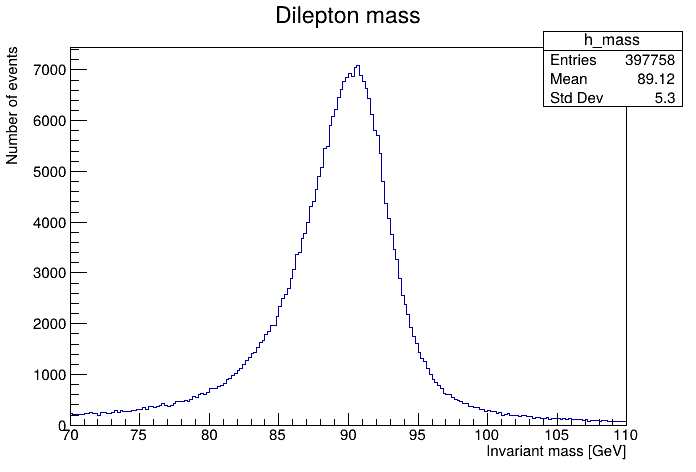

In [303]:
h_mass = ROOT.TH1F("h_mass", "Dilepton mass; Invariant mass [GeV]; Number of events", nBins, lowerEdge, upperEdge)
h_mass.Fill(np_data)
canvas = ROOT.TCanvas()
h_mass.Draw()
canvas.Draw()

### Gör anpassning för att kunna hitta centralvärdet, dvs det mest sannolika värdet. Vilken funktion ska anpassas? Behövs en summa av en modell som beskriver signalen ni söker ($Z$-bosoner) och en modell som beskriver bakgrunden? Prova er fram med olika funktioner och intervall för anpassningen. Titta på notebook [2-Fitting-with-ROOT](2-Fitting-with-ROOT.ipynb) igen för tips och hjälp.
____________________________________________________

**Tips:** Titta på dessa länkar för tips på en bra funktion att använda:
* Lite bakgrundsinformation om sk resonanspartiklar ($Z$-bosonen är en sådan): [Wikipedia](https://en.wikipedia.org/wiki/Resonance_(particle_physics))
* Funktioner som finns implementerade i ROOTs [TMath-klass](https://root.cern.ch/doc/master/namespaceTMath.html#a5dbbb839fede023ba8f1aece82cdbd7a)

**Ett ytterligare tips**: se till att funktionen ni anpassar har en parameter som tillåter att funktionen kan skalas till distributionen gjord ifrån datan - annars kommer datorns möjligheter att få funktionen att passa mätdatan bero på hur många events ni loopat över, och det är bara *formen* på distributionen vi vill åt!

In [322]:
# declare function for the model you want to fit to the data
func5 = ROOT.TF1("functionName", '[0]*TMath::BreitWigner(x,[1],[2]) + [3]*exp([4] + [5]*x) + [6]*TMath::BreitWignerRelativistic(x, [7],[8])', 20, 200)
func1 = ROOT.TF1("functionName", '[0]*TMath::BreitWignerRelativistic(x,[1],[2]) + [3]*exp([4] + [5]*x)', 20, 200)
func4 = ROOT.TF1("functionName", '[0]*TMath::BreitWignerRelativistic(x,[1],[2])', 70, 110)


breit = ROOT.TF1("breit", "[0]*TMath::BreitWigner(x,[mean],[gamma])")
func2 = ROOT.TF1("functionName", 'expo', 50, 150)

func1.SetParameter(0, 2000)     # Gaussian amplitude (from your data ~900)
func1.SetParameter(1, 90)
func1.SetParameter(2, 83)
func1.SetParameter(3, 5)

func5.SetParameter(6,100)
func5.SetParLimits(6,100,900)
func5.SetParameter(7,2)

func4.SetParameter(0, 5000)     # Gaussian amplitude (from your data ~900)
func4.SetParameter(1, 90)
func4.SetParameter(2, 83)



# Voigt = Breit-Wigner ⊗ Gaussian (natural width ⊗ detector resolution)
voigt = ROOT.TF1("voigt_fit", "[0]*TMath::Voigt(x-[1], [2], [3]) + [4] + [5]*x", 60, 120)

voigt.SetParameter(0, 8500)    # Voigt amplitude
voigt.SetParameter(1, 77)      # Peak position
voigt.SetParameter(2, 3)       # Gaussian sigma (detector resolution)
voigt.SetParameter(3, 2.5)     # Lorentzian gamma (natural width)
voigt.SetParameter(4, 200)     # Background constant
voigt.SetParameter(5, -1)      # Background slope



****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      6497.46
NDf                       =          194
Edm                       =  2.54332e-07
NCalls                    =          596
p0                        =      67963.6   +/-   152.873     
p1                        =      89.8487   +/-   0.00763173  
p2                        =      5.83344   +/-   0.0178566   
p3                        =     -220.359   +/-   38.4479     
p4                        =     -3.88636   +/-   0.193656    
p5                        =    0.0292113   +/-   0.00126391  


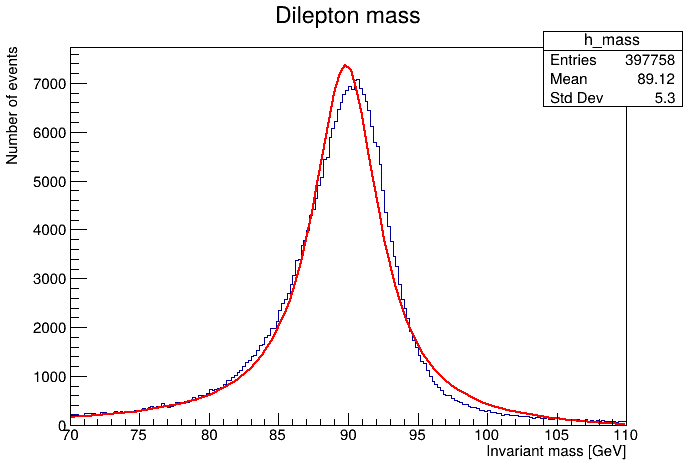

In [323]:
h_mass.Fit(func1, "S")
canvas.Draw()

#### Rapportskrivning

Läs nu igenom instruktionerna för rapportskrivningen noggrant i [4-LabReport](4-LabReport.ipynb).